# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/).**

In [18]:
# Run some setup code for this notebook.

from __future__ import print_function
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt  


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def rel_error(out, correct_out):
    return np.sum(abs(out - correct_out) / (abs(out) + abs(correct_out)))

In [7]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


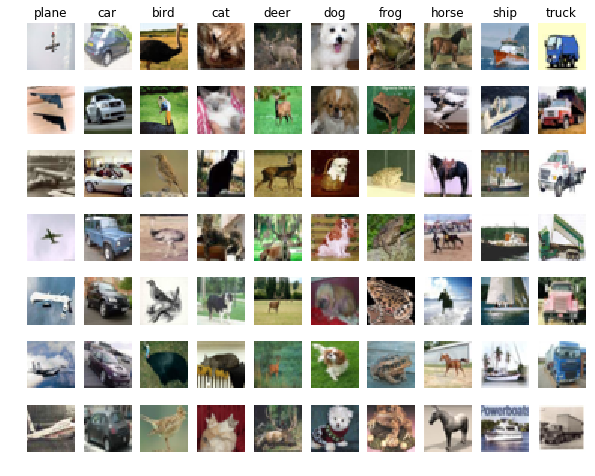

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)

X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [10]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [11]:
from classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [33]:
# Open classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

100%|██████████| 5000/5000 [00:00<00:00, 53975.19it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58255.35it/s]

100%|██████████| 5000/5000 [00:00<00:00, 52880.40it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57743.35it/s]

100%|██████████| 5000/5000 [00:00<00:00, 53607.36it/s]

100%|██████████| 5000/5000 [00:00<00:00, 52892.67it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61348.22it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61206.95it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


100%|██████████| 5000/5000 [00:00<00:00, 60625.87it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55610.41it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57234.34it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59061.73it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59685.00it/s]

100%|██████████| 5000/5000 [00:00<00:00, 34845.62it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56063.69it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64233.47it/s]

100%|██████████| 5000/5000 [00:00<00:00, 43376.73it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56643.81it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56836.16it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56143.39it/s]

 26%|██▌       | 128/500 [00:16<00:41,  9.03it/s]


100%|██████████| 5000/5000 [00:00<00:00, 58761.37it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56551.55it/s]

100%|██████████| 5000/5000 [00:00<00:00, 52040.58it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64589.56it/s]

100%|██████████| 5000/5000 [00:00<00:00, 62841.85it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61232.32it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55232.69it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56283.52it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55877.71it/s]

100%|██████████| 5000/5000 [00:00<00:00, 62572.97it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55254.22it/s]

100%|██████████| 5000/5000 [00:00<00:00, 54538.20it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55334.70it/s]

100%|██████████| 5000/5000 [00:00<00:00, 62224.68it/s]

100%|██████████| 5000/5000 [00:00<00:00, 47426.28it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55901.54it/s]

100%|██████████| 5000/5000 [00:00<00:00, 60329.04it/s]

100%|██████████| 5000/5000 [00:00<00:00, 54711.7

100%|██████████| 5000/5000 [00:00<00:00, 58476.11it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58834.56it/s]

100%|██████████| 5000/5000 [00:00<00:00, 54278.19it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58463.88it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58218.64it/s]

100%|██████████| 5000/5000 [00:00<00:00, 53958.39it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59074.54it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55821.49it/s]

100%|██████████| 5000/5000 [00:00<00:00, 52134.89it/s]

100%|██████████| 5000/5000 [00:00<00:00, 31950.18it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57767.53it/s]

100%|██████████| 5000/5000 [00:00<00:00, 54289.86it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58767.62it/s]

100%|██████████| 5000/5000 [00:00<00:00, 60299.03it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55081.09it/s]

100%|██████████| 5000/5000 [00:00<00:00, 53043.58it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57541.35it/s]

 59%|█████▉    | 295/500 [00:33<00:26,  7.73it/s

100%|██████████| 5000/5000 [00:00<00:00, 55786.30it/s]

100%|██████████| 5000/5000 [00:00<00:00, 60170.66it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64055.71it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64416.36it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64151.14it/s]

100%|██████████| 5000/5000 [00:00<00:00, 63330.51it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59299.37it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61468.87it/s]

100%|██████████| 5000/5000 [00:00<00:00, 63163.23it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58444.82it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58409.82it/s]

100%|██████████| 5000/5000 [00:00<00:00, 50123.73it/s]

100%|██████████| 5000/5000 [00:00<00:00, 45205.43it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57420.51it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57956.23it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59843.74it/s]

100%|██████████| 5000/5000 [00:00<00:00, 64347.58it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57579.1

100%|██████████| 5000/5000 [00:00<00:00, 55470.53it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56086.48it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55569.15it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58324.70it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57536.77it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57494.50it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57908.38it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61899.59it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57241.06it/s]

100%|██████████| 5000/5000 [00:00<00:00, 56303.01it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57436.39it/s]

100%|██████████| 5000/5000 [00:00<00:00, 41575.18it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55535.75it/s]

100%|██████████| 5000/5000 [00:00<00:00, 45829.97it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55806.04it/s]

100%|██████████| 5000/5000 [00:00<00:00, 52086.07it/s]


100%|██████████| 5000/5000 [00:00<00:00, 55430.06it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61605.02it/s]

100%|██████████| 5000/5000 [00:00<00:00, 60307.70it/s]

100%|██████████| 5000/5000 [00:00<00:00, 46768.73it/s]

100%|██████████| 5000/5000 [00:00<00:00, 54044.88it/s]

100%|██████████| 5000/5000 [00:00<00:00, 57431.67it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61039.67it/s]

100%|██████████| 5000/5000 [00:00<00:00, 62271.24it/s]

100%|██████████| 5000/5000 [00:00<00:00, 63628.54it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55895.14it/s]

100%|██████████| 5000/5000 [00:00<00:00, 55103.09it/s]

100%|██████████| 5000/5000 [00:00<00:00, 62155.70it/s]

100%|██████████| 5000/5000 [00:00<00:00, 53328.18it/s]

100%|██████████| 5000/5000 [00:00<00:00, 59525.76it/s]

100%|██████████| 5000/5000 [00:00<00:00, 61897.40it/s]

100%|██████████| 5000/5000 [00:00<00:00, 53288.48it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58292.27it/s]

100%|██████████| 5000/5000 [00:00<00:00, 58959.4

(500, 5000)


In [34]:
print(dists[0][0])

3803.92350080808


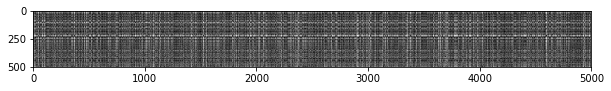

In [35]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [36]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [15]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


You should expect to see a slightly better performance than with `k = 1`.

## Frobenius Norm
To ensure that our vectorized implementation is correct, we make sure that it agrees with the naive implementation. There are many ways to decide whether two matrices are similar; one of the simplest is **the Frobenius norm**.
* Frobenius norm of $m\times n$ matrix $A$ is defined as the square root of the sum of the absolute squares of its elements,:
$$\|A\|_F=\sqrt{\sum\limits_{i=1}^m\sum\limits_{j=1}^nA_{ij}^2}$$

In [16]:
def Frobenius_norm(A):
    Fnorm = None
    ################################################################################
    # TODO:                                                                        #
    # Implement a function to calculate Frobenius Norm of matrix A.                #
    # Hint: It is fine to use 2-nested for-loop. However, you can implement this   #
    # function with matrix calculation, which is much faster.                      #
    # NOTE: numpy provides built-in function for Frobenius Norm, in this exercise, #
    # you are required to implement this function.                                 #
    ################################################################################
    pass
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    return Fnorm

In [17]:
# Check the accuracy of your implementation
A = np.random.rand(3,2)
print('The difference: ', rel_error(Frobenius_norm(A), np.linalg.norm(A)))

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)
print('dists_two: ', dists_two)
print('dists: ', dists)
# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation